In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

## Config
dataset = "training_1"
path = "../" + dataset +"/"
kfold_split = 10
nan_to_neg = True
biased_regress = True
normal_equations = True
mm = False
std = False
numpy_load = False

## ESN parameters
N_def = 200         # Neurons
scale_def = 1.0   # scaling
mem_def = 0.5      # memory
exponent_def = 0.1    # sigmoid exponent


# Script name struct for report
script_name = 'template1'
dl_ = '_'
name_struct_meta = "_N_scale_mem"
name_struct = [dl_, N_def, dl_, scale_def, dl_, mem_def]
name_struct = ''.join(str(e) for e in name_struct)


In [2]:
## Imports
import numpy as np
import os
import ESNtools
import matplotlib.pyplot as plt

In [3]:
## Create the feature matrix
features = []
patient = []
sepsis_label = []
dataloaded = False



In [4]:
## Read data 
## Folder and files
fnames = os.listdir(path)  
fnames.sort()
if 'README.md' in fnames:
    fnames.remove('README.md')
print('last file: ', fnames[-1])

n = len(fnames)
print(n, ' files present')

## read data
for i in range(n):
    input_file = os.path.join(path, fnames[i])
    if i ==0:
        data, sep_lab, columns = ESNtools.read_challenge_data_label(input_file, return_header=True)
    else: 
        data, sep_lab = ESNtools.read_challenge_data_label(input_file)
    features.append(data)
    sepsis_label.append(sep_lab)
    pat = i * np.ones((sep_lab.shape), dtype=np.int)
    patient.append(pat)

feature_matrix = np.concatenate(features)
del(features)
sepsis_label = np.concatenate(sepsis_label)
patient = np.concatenate(patient)
dataloaded = True

last file:  p05000.psv
5000  files present


In [5]:
## Separate pointers
feature_phys = feature_matrix[:,:-6]    ## Physiology
feature_demog = feature_matrix[:,-6:]   ## Demographics

In [6]:
## Get sepsis patients
## patient_sep indicates (every sample), whether the patient is septic
## patient_sep_index indicates the patient number corresponding to septic patients
## patient_healthy_idx indicates the patient number corresponding to healthy patients
patient_sep = np.zeros(len(sepsis_label),dtype=np.int)
for i in range(n):
    i_pat = np.where(patient==i)[0]
    patient_sep[i_pat] = int(np.sum(sepsis_label[i_pat])>0)*np.ones(len(i_pat), dtype=np.int)
    
patient_sep_idx = patient[np.where(patient_sep!=0)[0]]
patient_healthy_idx = patient[np.where(patient_sep==0)[0]]

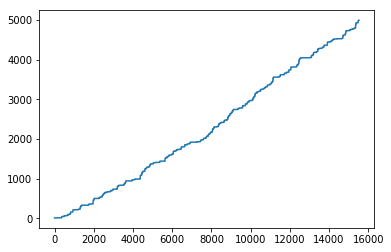

In [7]:
plt.plot((patient_sep_idx))

24 entries x 40


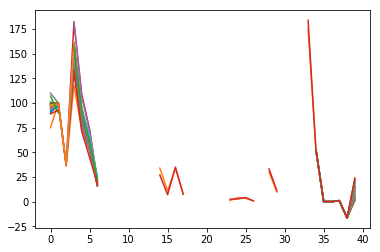

In [8]:
i_pat = 42

def plot_patient_features(n_pat, features, patient_array):
    plot_j = np.where(patient == n_pat)[0]
    for j in range (len(plot_j)):
        plt.plot(features[plot_j[j],:])    
    print(len(plot_j), "entries x", np.shape(features)[1])
    return

def print_patient_features(n_pat, features, patient_array):
    print("Patient", n_pat)
    print_j = np.where(patient == n_pat)[0]
    for j in range (len(print_j)):
        print(features[print_j[j],:])    
    return

plot_patient_features(i_pat, feature_matrix, patient)

In [9]:
n_pat = i_pat
n_pat

42

Healthy


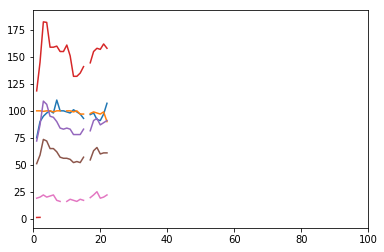

In [10]:
plot_j = np.where(patient == n_pat)[0]
A = feature_phys[plot_j[0]:plot_j[-1],:]
fig, ax = plt.subplots()
plotimg = ax.plot(A)
ax.set_xlim(0,100)
if patient_sep[plot_j][0] == 0:
    print ("Healthy")
else:
    print ("Septic")

## Fix NaN interpolation

In [11]:
# Fix boundary nans (replicate head/tail vals)
def nan_bounds(feats):
    nanidx = np.where(np.isnan(feats))[0]
    pointer_left = 0
    pointer_right = len(feats)-1
    fix_left = pointer_left in nanidx
    fix_right = pointer_right in nanidx
    while fix_left:
        if pointer_left in nanidx:
            pointer_left += 1
            # print("pointer_left:", pointer_left)
        else:
            val_left = feats[pointer_left]
            feats[:pointer_left] = val_left*np.ones((1,pointer_left),dtype=np.float)
            fix_left = False

    while fix_right:
        if pointer_right in nanidx:
            pointer_right -= 1
            # print("pointer_right:", pointer_right)
        else:
            val_right = feats[pointer_right]
            feats[pointer_right+1:] = val_right*np.ones((1,len(feats)-pointer_right-1),dtype=np.float)
            fix_right = False 
        
# nan interpolation
def nan_interpolate(feats):
    nanidx = np.where(np.isnan(feats))[0]
    nan_remain = len(nanidx)
    nanid = 0
    while nan_remain > 0:
        nanpos = nanidx[nanid] 
        nanval = feats[nanpos-1]
        nan_remain -= 1

        nandim = 1
        initpos = nanpos

        # Check whether it extends
        while nanpos+1 in nanidx:
            nanpos += 1
            nanid += 1
            nan_remain -= 1
            nandim += 1
            # Average sides
            if np.isfinite(feats[nanpos+1]):
                nanval = 0.5 * (nanval + feats[nanpos+1])

        # Single value average    
        if nandim == 1:
            nanval = 0.5 * (nanval + feats[nanpos+1])
        feats[initpos:initpos+nandim] = nanval*np.ones((1,nandim),dtype=np.double)
        nanpos += 1
        nanid += 1    


In [12]:
## Fill nan when not all-row
for i in range(A.shape[1]):
    ifeat = A[:,i]
    if np.sum(np.isnan(ifeat)) < len(ifeat):
        nan_bounds(ifeat)
        nan_interpolate(ifeat)
        # print(ifeat)

Healthy


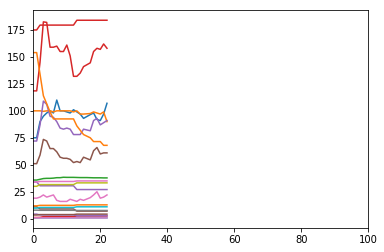

In [13]:
fig, ax = plt.subplots()
plotimg = ax.plot(A)
ax.set_xlim(0,100)
if patient_sep[plot_j][0] == 0:
    print ("Healthy")
else:
    print ("Septic")

Healthy


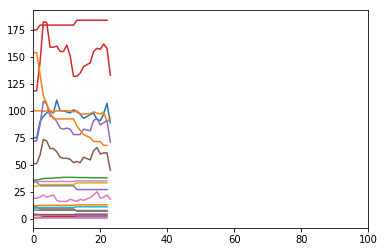

In [14]:
fig, ax = plt.subplots()
plotimg = ax.plot(feature_phys[plot_j,:])
ax.set_xlim(0,100)
if patient_sep[plot_j][0] == 0:
    print ("Healthy")
else:
    print ("Septic")

In [15]:
# # FAKE
# ifeat[0] = np.nan
# ifeat[1] = np.nan
# ifeat[-3] = np.nan
# ifeat[-2] = np.nan
# ifeat[-1] = np.nan
# ifeat[16] = np.nan
# ifeat[17] = np.nan
# ifeat[18] = np.nan
# ifeat[19] = 88.0
# ifeat[20] = np.nan

# nanidx = np.where(np.isnan(ifeat))[0]
# nanidx

In [16]:
# How to use
if np.sum(np.isnan(ifeat)) < len(ifeat):
    nan_bounds(ifeat)
    nan_interpolate(ifeat)
    ifeat

array([175. , 175. , 179.5, 179.5, 179.5, 179.5, 179.5, 179.5, 179.5,
       179.5, 179.5, 179.5, 179.5, 184. , 184. , 184. , 184. , 184. ,
       184. , 184. , 184. , 184. , 184. ])